# The driven classical oscillator

Copyright (C) 2021, Oriol Vendrell <oriol.vendrell@uni-heidelberg.de>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

In [44]:
import numpy as np
import scipy.integrate as intgr
from scipy.integrate import complex_ode, ode
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
MEDIUM_SIZE = 10
plt.rc('axes', labelsize=MEDIUM_SIZE)
#plt.rc('text', usetex=True)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [45]:
MEDIUM_SIZE = 14
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rc('axes', labelsize=MEDIUM_SIZE)

In [46]:
# A couple of constants
ev2au = 0.03674930882476195
au2ev = 1.0/ev2au
au2fs = 0.024188843341
fs2au = 1.0/au2fs
mp = 1836 # proton mass

## Potential, forces and classical equations of motion

A charged particle with charge $q$ is subject to the harmonic potential $V(x) = \frac{1}{2}m\omega^2 x^2$ and to the oscillatory electric field $E(t) = E_0 \sin(\omega_E t)$. The force done by the harmonic potential reads $F_V = -m\omega^2 x$ and the oscillatory force done by the field on the charge reads $F_E(t) = q E(t)$.

The Newton's equations for the velocity and position of the particle thus read:

\begin{align}
    m \frac{d v}{dt} & = -m\omega^2 x -\gamma v + q E_0 \sin(\omega_E t) \\
    \frac{dx}{dt} & = v
\end{align}

This a system of first order differential equations, which we will solve numerically.

In [102]:
M = mp
W = 0.1*ev2au
Q = 1.0
g = 0.5

WE = 0.1*ev2au
E0 = 0.002

T = 2.0*np.pi/WE
NC = 500
tfinalE = NC*T

In [96]:
def V(x, m = M, w = W):
    return 0.5*m*w**2*x**2

def FV(x, m = M, w = W):
    return -m*w**2*x

def FE(t, wE = WE, e0 = E0, q = Q, t0 = tfinalE):
    if t < t0:
        return e0*q*np.sin(wE*t)
    else:
        return 0.0

def FF(v, g = g):
    return -g*v

In [103]:
def integrate_newton(x0, v0, tf, m = M, w = W, q = Q, wE = WE, e0 = E0, g = g, nc = NC, Nt = 500):
    t0 = 2.0*np.pi/wE*nc
    # Define the function that returns the first order derivatives
    def dfunc(time, coords):
        # coords[0]: x; position
        # coords[1]: v; velocity
        d = (coords[1], FV(coords[0], m, w)/m + FE(time, wE, e0, q, t0)/m + FF(coords[1], g)/m)
        d = np.asarray(d)
        return d
    
    t = np.linspace(0, tf, Nt)
    f = np.zeros((Nt, 2), float)
    f0 = np.array([x0, v0], float)

    # Initialize the differential equation solver
    solver = ode(dfunc)
    solver.set_integrator('vode', atol=1.0e-8)
    solver.set_initial_value(f0, t[0])
    
    # Integrate!
    f[0] = f0
    k = 1
    while solver.successful() and solver.t < tf:
        solver.integrate(t[k])
        f[k] = solver.y
        k += 1
    
    # Return solution
    X = f.T[0] # T transposes the f matrix. psi(x) and s(x) are in the rows of the transposed f matrix
    V = f.T[1]
    return t, X, V

In [118]:
t, X, V = integrate_newton(0.0, 0.0, 2000*fs2au, w = 0.1*ev2au, wE = 0.1*ev2au, g = 1.0, nc = 10, Nt=1000)

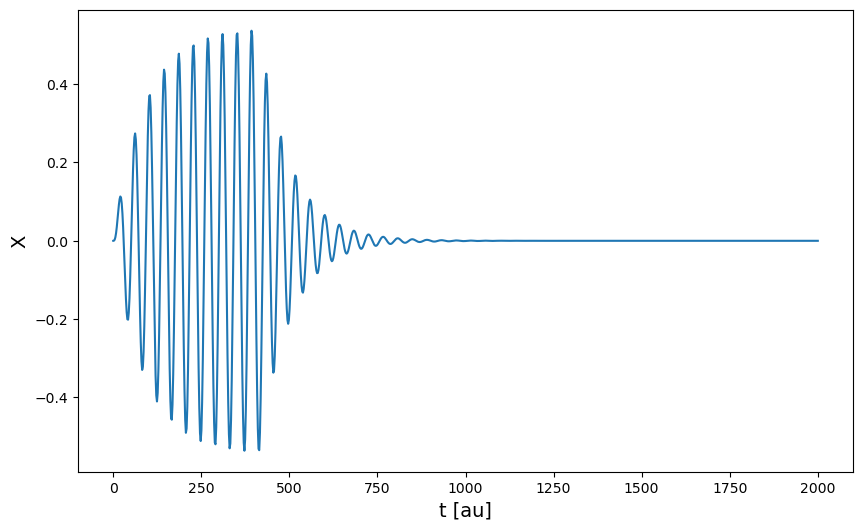

In [119]:
plt.xlabel('t [au]')
plt.ylabel('X')
plt.plot(t*au2fs, X)
#plt.plot(t*au2fs, V)

### Energy gain of the particle through the electric field

In [11]:
# Total energy of the particle, H = T + V
def H(X, V, m=M, w=W):
    return 0.5*m*(V**2 + w**2*X**2)

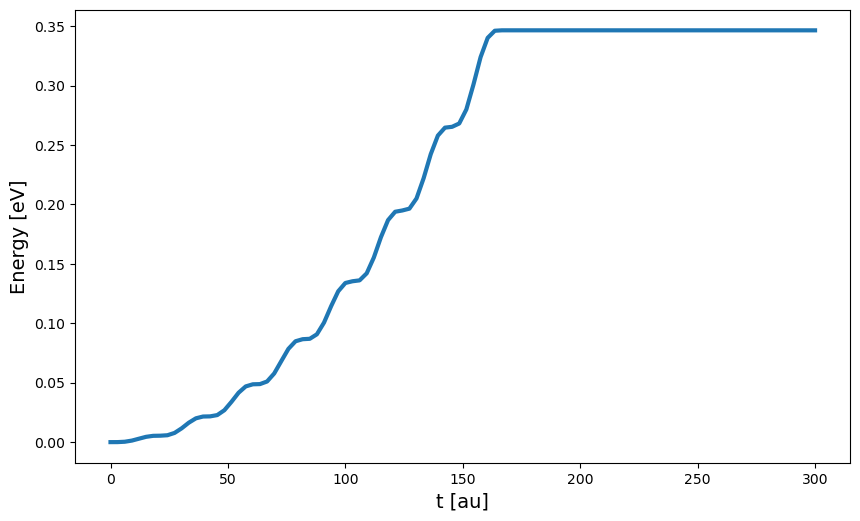

In [12]:
t, X, V = integrate_newton(0.0, 0.0, 300*fs2au, w = 0.1*ev2au, wE = 0.1*ev2au, nc = 4, Nt=100)
plt.xlabel('t [au]')
plt.ylabel('Energy [eV]')
plt.plot(t*au2fs, H(X, V)*au2ev, linewidth=3.0)

In a classical description of the oscillator, all final energies are possible. Every duration of the electromagnetic field leads to a different final energy of the system.

If now this system is left alone until it relaxes by emitting light, classically it should re-emitt its excess energy $E_{final}$. *Quantum mechanically, only very specific energies (frequencies) are measured, namely $E_{ph} = \hbar\omega$!!*

### Resonant energy transfer from the field

We focus now on the final energy of the oscillatory charge. The key parameter is the frequency difference between the harmonic oscillator of the charge, $\omega$, and the frequency of the oscillatory driving force $\omega_E$. This quantity is often called "detuning", $\Delta = \omega_E - \omega$. At zero detuning the driving force and the system are resonant and the energy transfer is maximally efficient, whereas the efficiency of the energy transfer quickly decreases as $|\Delta|$ increases. 

In [13]:
Nw = 160
field_freqs = np.linspace(0.01*ev2au, 0.4*ev2au, Nw)
final_energies = np.zeros(Nw, float)

In [14]:
for k in range(0, Nw):
    t, X, V = integrate_newton(0.0, 0.0, 300*fs2au, w = 0.1*ev2au, wE = field_freqs[k], nc = 4, Nt=100)
    final_energies[k] = H(X[-1], V[-1])

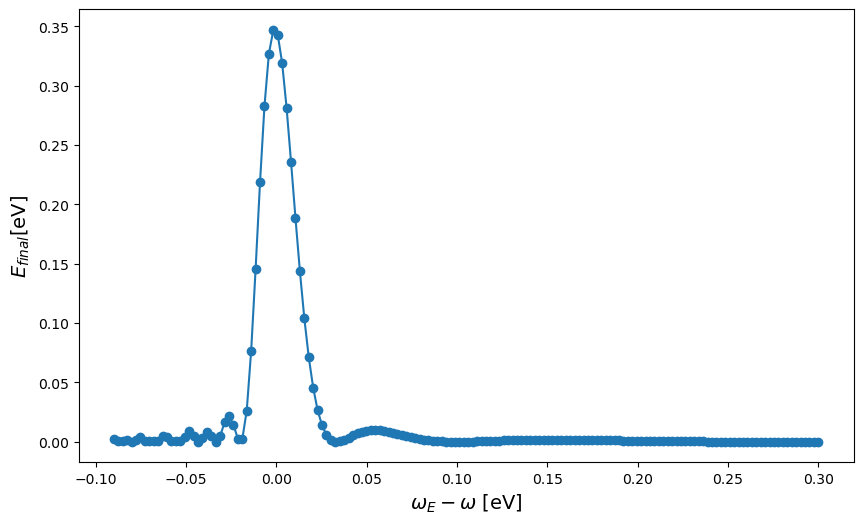

In [15]:
plt.xlabel('$\omega_E - \omega$ [eV]')
plt.ylabel('$E_{final}$[eV]')
plt.plot(field_freqs*au2ev - 0.1, final_energies*au2ev, '-o')